# Описание задачи:
## Имеются твиты пользователей о различных катастрофах. Каждому твиту присвоена метка 1 или 0, которая говорит, что твит описывает реальную катастрофу или нет. На основании этих данных необходимо построить классификатор.

In [ ]:
# Чтение данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Обработка данных
import string, nltk, re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Построение Deep Learning моделей
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

# Построение ML моделей
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb


# Оценка моделей
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_val_score

# Считывание данных

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [ ]:
test.head(3)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


# EDA

In [ ]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


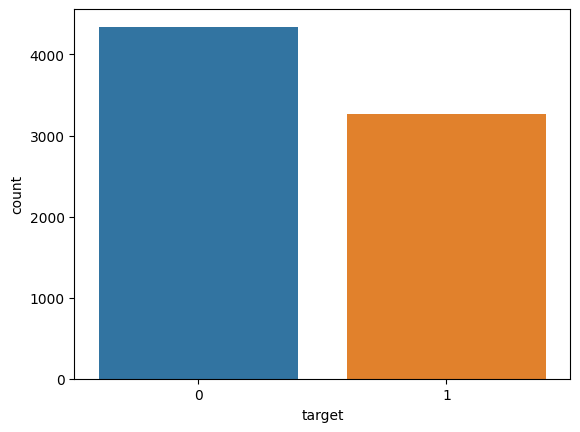

In [ ]:
# Количество примеров, относящихся к каждому классу
sns.countplot(x=train["target"]);

In [ ]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


## Избавимся от лишних колонок, не имеющих отношение к тексту твита или его метке

In [ ]:
def drop_col(data):
    columns = ["id", "keyword", "location"]
    for col in columns:
        data.drop(columns=col, axis=1, inplace=True)
    return data

train = drop_col(train)
test = drop_col(test)

In [ ]:
train.head(3)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1


In [ ]:
test.head(3)

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."


In [ ]:
train["len"] = train["text"].apply(len)
test["len"] = test["text"].apply(len)

In [ ]:
train.head(5)

,text,target,len
0,Our Deeds are the Reason of this #earthquake M...,1,69
1,Forest fire near La Ronge Sask. Canada,1,38
2,All residents asked to 'shelter in place' are ...,1,133
3,"13,000 people receive #wildfires evacuation or...",1,65
4,Just got sent this photo from Ruby #Alaska as ...,1,88


In [ ]:
train.describe()

,target,len
count,7613.00000,7613.000000
mean,0.42966,101.037436
std,0.49506,33.781325
min,0.00000,7.000000
25%,0.00000,78.000000
50%,0.00000,107.000000
75%,1.00000,133.000000
max,1.00000,157.000000


# Обработка текста

## 1 - Очистка пунктуации
## 2 - Удаление стоп-слов
## 3 - Лемматизация (приведение к начальной форме слова)

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

punc = list(string.punctuation)
stop_word = stopwords.words("english")
Lemmatize = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def transform_text(text):
    text = text.lower()
    new_text = " ".join([Lemmatize.lemmatize(word) for word in word_tokenize(text) if ((word not in punc) and (word not in stop_word))])

    new_text = re.sub("[^a-z]", " ", new_text)

    return new_text

In [ ]:
train["Cleaning-text"] = train["text"].apply(transform_text)
test["Cleaning-text"] = test["text"].apply(transform_text)

In [ ]:
train.head(10)

,text,target,len,Cleaning-text
0,Our Deeds are the Reason of this #earthquake M...,1,69,deed reason earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,133,resident asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",1,65,people receive wildfire evacuation orde...
4,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo ruby alaska smoke wildfire pour...
5,#RockyFire Update => California Hwy. 20 closed...,1,110,rockyfire update california hwy closed dire...
6,#flood #disaster Heavy rain causes flash flood...,1,95,flood disaster heavy rain cause flash flooding...
7,I'm on top of the hill and I can see a fire in...,1,59,m top hill see fire wood
8,There's an emergency evacuation happening now ...,1,79,s emergency evacuation happening building acr...
9,I'm afraid that the tornado is coming to our a...,1,52,m afraid tornado coming area


In [ ]:
train["len_after_clean"] = train["Cleaning-text"].apply(len)
test["len_after_clean"] = test["Cleaning-text"].apply(len)

In [ ]:
train.head(5)

,text,target,len,Cleaning-text,len_after_clean
0,Our Deeds are the Reason of this #earthquake M...,1,69,deed reason earthquake may allah forgive u,42
1,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada,37
2,All residents asked to 'shelter in place' are ...,1,133,resident asked shelter place notified officer...,86
3,"13,000 people receive #wildfires evacuation or...",1,65,people receive wildfire evacuation orde...,58
4,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo ruby alaska smoke wildfire pour...,54


## Удаление лишних колонок (до предобработки данных)

In [ ]:
def drop_extra(data):
    columns = ["text", "len"]
    for col in columns:
        data.drop(columns=col, axis=1, inplace=True)
    return data

train = drop_extra(train)
test = drop_extra(test)

In [ ]:
train.head(10)

,target,Cleaning-text,len_after_clean
0,1,deed reason earthquake may allah forgive u,42
1,1,forest fire near la ronge sask canada,37
2,1,resident asked shelter place notified officer...,86
3,1,people receive wildfire evacuation orde...,58
4,1,got sent photo ruby alaska smoke wildfire pour...,54
5,1,rockyfire update california hwy closed dire...,88
6,1,flood disaster heavy rain cause flash flooding...,82
7,1,m top hill see fire wood,29
8,1,s emergency evacuation happening building acr...,56
9,1,m afraid tornado coming area,33


In [ ]:
test.head(5)

,Cleaning-text,len_after_clean
0,happened terrible car crash,27
1,heard earthquake different city stay safe ever...,50
2,forest fire spot pond goose fleeing across str...,54
3,apocalypse lighting spokane wildfire,36
4,typhoon soudelor kill china taiwan,37


# Разделение данных на X y

In [ ]:
X = train["Cleaning-text"]
Y = train["target"]

# #------------------------------------------------------------------------------------------------------#

# Кодирование текста

## 1 подход - Токенизация

In [ ]:
print(X[0], X[1], X[2], X[3], sep='\n')

deed reason earthquake may allah forgive u
forest fire near la ronge sask canada
resident asked  shelter place notified officer evacuation shelter place order expected
       people receive wildfire evacuation order california


In [ ]:
X

0              deed reason earthquake may allah forgive u
1                   forest fire near la ronge sask canada
2       resident asked  shelter place notified officer...
3              people receive wildfire evacuation orde...
4       got sent photo ruby alaska smoke wildfire pour...
                              ...                        
7608    two giant crane holding bridge collapse nearby...
7609    aria ahrary thetawniest control wild fire cali...
7610    m           utc  km volcano hawaii http   t co...
7611    police investigating e bike collided car littl...
7612    latest home razed northern california wildfire...
Name: Cleaning-text, Length: 7613, dtype: object

In [ ]:
# Tokenization - Training Data

tokenize = Tokenizer(oov_token="<OOV>")
tokenize.fit_on_texts(X)
word_index = tokenize.word_index

data_sequance = tokenize.texts_to_sequences(X)

# Padding_Sequances
data_padding = pad_sequences(data_sequance, maxlen=150, padding="pre", truncating="pre")

In [ ]:
data_sequance[0]

[4382, 493, 197, 95, 1472, 4383, 11]

In [ ]:
data_padding.shape, Y.value_counts()

((7613, 150),
 0    4342
 1    3271
 Name: target, dtype: int64)

In [ ]:
input_length = max(len(seq) for seq in data_sequance)

vocabulary_size = len(word_index) + 1

input_length, vocabulary_size

(30, 20965)

# Oversampling для избавления от дисбаланса классов

In [ ]:
smote = SMOTE()
new_data_padding, new_y = smote.fit_resample(data_padding, Y)

In [ ]:
new_y.value_counts()

1    4342
0    4342
Name: target, dtype: int64

In [ ]:
Y.value_counts()

0    4342
1    3271
Name: target, dtype: int64

#  Transform Label To OneHotEncoder 0 --> [0, 1]

In [ ]:
Y

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [ ]:
# label  = to_categorical(new_y, 2)
label  = to_categorical(Y, 2)

label[0:5]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
label

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

# %--------------------------------------------------------------------------------------------%

## 2 - Подход TfidVectorizer

In [ ]:
TFID = TfidfVectorizer(stop_words="english", max_df=0.8, ngram_range=(1, 2))
new_TFID = TFID.fit_transform(X)
test_x = TFID.transform(test["Cleaning-text"])

# Splitting Data To Training & Testing

In [ ]:
# TF_IDF
x_train, x_test, y_train, y_test = train_test_split(new_TFID, Y, train_size=0.8, random_state=42)

In [ ]:
# Tokenize
x_train_dl, x_test_dl, y_train_dl, y_test_dl = train_test_split(new_data_padding, new_y, train_size=0.8)

# Building Machine Learning Model

## 1 - XGBoostClassifier ==> tfidf

In [ ]:
model_xgb = xgb.XGBClassifier()

model_xgb.fit(x_train, y_train)

print(f"The predict Score Train is ==> {model_xgb.score(x_train, y_train)}")
print("%----------------------------------------------------------%")
print(f"The predict Score Test is ==> {model_xgb.score(x_test, y_test)}")

The predict Score Train is ==> 0.8660098522167488
%----------------------------------------------------------%
The predict Score Test is ==> 0.7695338148391333


## 1 - XGBoostClassifier ==> tokenizer

In [ ]:
model_xgb_DL = xgb.XGBClassifier()

model_xgb_DL.fit(x_train_dl, y_train_dl)

print(f"The predict Score Train is ==> {model_xgb_DL.score(x_train_dl, y_train_dl)}")
print("%----------------------------------------------------------%")
print(f"The predict Score Test is ==> {model_xgb_DL.score(x_test_dl, y_test_dl)}")

The predict Score Train is ==> 0.9543687922844393
%----------------------------------------------------------%
The predict Score Test is ==> 0.7023603914795624


# 2 - AdaBoostClassifier ==> tfidf

In [ ]:
Adaboost = AdaBoostClassifier(n_estimators=200,
                              learning_rate=0.2)


Adaboost.fit(x_train, y_train)

print(f"The predict Score Train is ==> {Adaboost.score(x_train, y_train)}")
print("%----------------------------------------------------------%")
print(f"The predict Score Test is ==> {Adaboost.score(x_test, y_test)}")

The predict Score Train is ==> 0.7853858784893267
%----------------------------------------------------------%
The predict Score Test is ==> 0.7550886408404465


# 2 - AdaBoostClassifier ==> tokenizer

In [ ]:
Adaboost = AdaBoostClassifier(n_estimators=200,
                              learning_rate=0.2)


Adaboost.fit(x_train_dl, y_train_dl)

print(f"The predict Score Train is ==> {Adaboost.score(x_train_dl, y_train_dl)}")
print("%----------------------------------------------------------%")
print(f"The predict Score Test is ==> {Adaboost.score(x_test_dl, y_test_dl)}")

The predict Score Train is ==> 0.6716568302864546
%----------------------------------------------------------%
The predict Score Test is ==> 0.6522740356937248


# 3 - RandomForest ==> tfidf

In [ ]:
model_rd = RandomForestClassifier()
model_rd.fit(x_train, y_train)

print(f"The predict Score Train is ==> {model_rd.score(x_train, y_train)}")
print("%----------------------------------------------------------%")
print(f"The predict Score Test is ==> {model_rd.score(x_test, y_test)}")

The predict Score Train is ==> 0.99688013136289
%----------------------------------------------------------%
The predict Score Test is ==> 0.7754432042022325


# 3 - RandomForest ==> tokenizer

In [ ]:
model_rd_DL = RandomForestClassifier()
model_rd_DL.fit(x_train_dl, y_train_dl)

print(f"The predict Score Train is ==> {model_rd_DL.score(x_train_dl, y_train_dl)}")
print("%----------------------------------------------------------%")
print(f"The predict Score Test is ==> {model_rd_DL.score(x_test_dl, y_test_dl)}")

The predict Score Train is ==> 0.9972650064776163
%----------------------------------------------------------%
The predict Score Test is ==> 0.7127230857800806


#  Building Deep Learning Model

## Embeding Layers

In [ ]:
model = tf.keras.models.Sequential(
    [
        Embedding(vocabulary_size, 100, input_length=150),
        GlobalAveragePooling1D(),
        Dense(24, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
model.compile(optimizer="adam", loss=k.losses.BinaryCrossentropy(), metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 100)          2096500   
                                                                 
 global_average_pooling1d_3  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 24)                2424      
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 2098949 (8.01 MB)
Trainable params: 2098949 (8.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Sequential ==> Tokenizer

In [ ]:
history = model.fit(x_train_dl, y_train_dl, epochs=15,
                    validation_data=(x_test_dl, y_test_dl), verbose=2)

Epoch 1/15
218/218 - 9s - loss: 0.6907 - accuracy: 0.5294 - val_loss: 0.6841 - val_accuracy: 0.5636 - 9s/epoch - 42ms/step
Epoch 2/15
218/218 - 6s - loss: 0.6416 - accuracy: 0.7118 - val_loss: 0.5999 - val_accuracy: 0.6857 - 6s/epoch - 29ms/step
Epoch 3/15
218/218 - 7s - loss: 0.4800 - accuracy: 0.7970 - val_loss: 0.5030 - val_accuracy: 0.7473 - 7s/epoch - 31ms/step
Epoch 4/15
218/218 - 6s - loss: 0.3499 - accuracy: 0.8634 - val_loss: 0.4751 - val_accuracy: 0.7634 - 6s/epoch - 29ms/step
Epoch 5/15
218/218 - 7s - loss: 0.2683 - accuracy: 0.8997 - val_loss: 0.4779 - val_accuracy: 0.7761 - 7s/epoch - 31ms/step
Epoch 6/15
218/218 - 8s - loss: 0.2094 - accuracy: 0.9240 - val_loss: 0.4951 - val_accuracy: 0.7766 - 8s/epoch - 37ms/step
Epoch 7/15
218/218 - 7s - loss: 0.1644 - accuracy: 0.9421 - val_loss: 0.5209 - val_accuracy: 0.7824 - 7s/epoch - 30ms/step
Epoch 8/15
218/218 - 10s - loss: 0.1339 - accuracy: 0.9531 - val_loss: 0.5426 - val_accuracy: 0.7772 - 10s/epoch - 44ms/step
Epoch 9/15
218

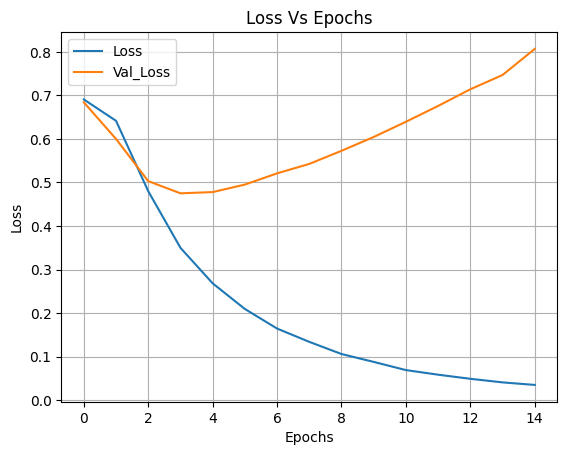

In [ ]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Val_Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title("Loss Vs Epochs")

plt.legend()
plt.grid()

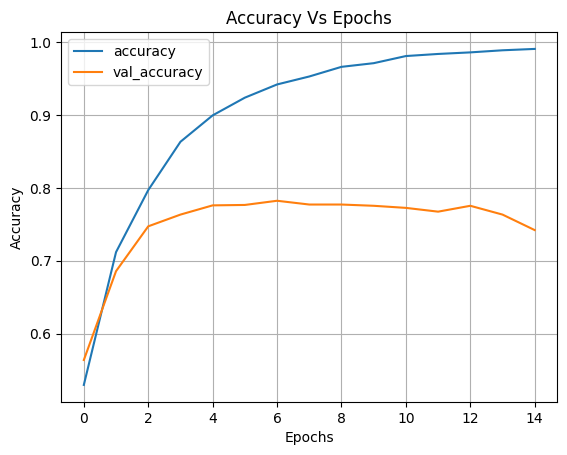

In [ ]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Accuracy Vs Epochs")

plt.legend()
plt.grid()